In [1]:
import json
import pickle
import numpy as np
import matplotlib.pyplot as plt
import datetime as datetime

In [2]:
business_review_dict = pickle.load(open("business_reviews.pickle", "rb"))

In [19]:
datetime.datetime(2016, 12, 1)

datetime.datetime(2016, 12, 1, 0, 0)

In [37]:
relevant = {}
business_info = {}
with open("yelp_academic_dataset_business.json") as f:
    for line in f:
        json_line = json.loads(line)

        city = json_line["city"]
        business = json_line["business_id"]
        reviews = business_review_dict[business]
        num_reviews = len(reviews)
        avg_star = sum(reviews)/float(num_reviews)
        
        if city == "Phoenix":
            if num_reviews > 1500 and "Restaurants" in json_line["categories"]:
                print(json_line["name"])
                relevant[business] = []
                business_info[business] = json_line

Lux Central
Bobby Q
Pizzeria Bianco


In [38]:
with open("yelp_academic_dataset_review.json") as f:
    for line in f:
        json_line = json.loads(line)
        if json_line["business_id"] in relevant:
            relevant[json_line["business_id"]].append(json_line)

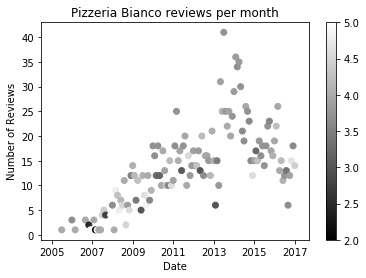

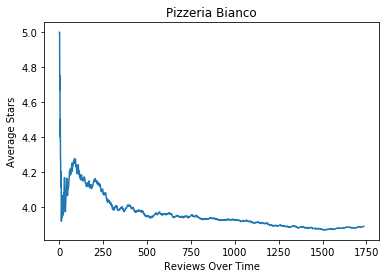

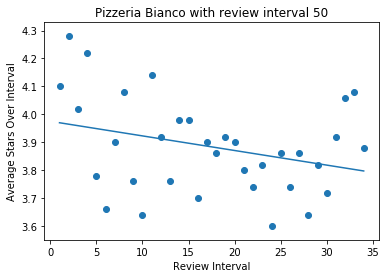

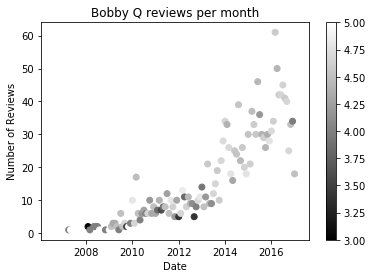

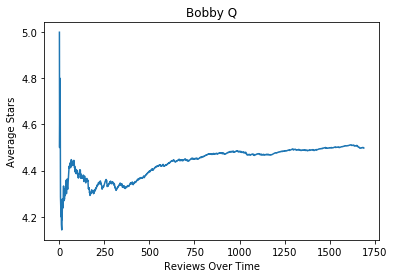

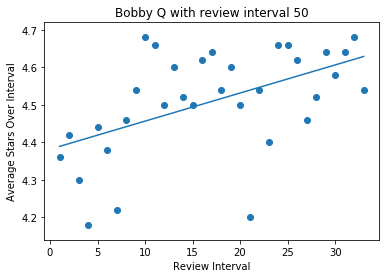

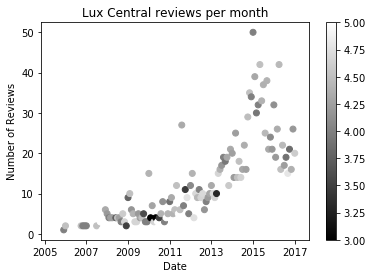

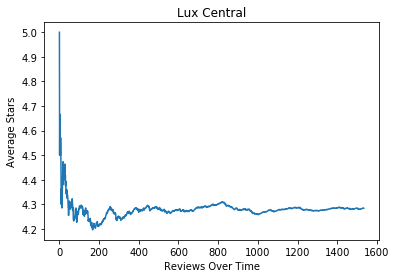

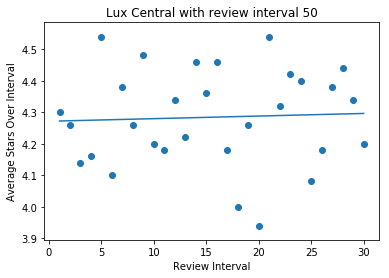

In [39]:
for b_id, reviews in relevant.items():
    counter = 0
    business = business_info[b_id]
    name = business["name"]
    sorted_reviews = sorted(reviews, key=lambda x: datetime.datetime.strptime(x['date'], '%Y-%m-%d'))
    seen_stars = []
    
    x = []
    avg = []
    
    x_interval = []
    avg_interval = []
    interval = 50
    
    date_to_count = {}
    date_to_reviews = {}
    for rev in sorted_reviews:
        date = datetime.datetime.strptime(rev['date'], '%Y-%m-%d')
        month = int(date.strftime('%m'))
        year = int(date.strftime('%Y'))
        if (year, month) in date_to_count:
            date_to_count[(year, month)] += 1
            date_to_reviews[(year, month)].append(rev["stars"])
        else:
            date_to_count[(year, month)] = 1
            date_to_reviews[(year, month)] = [rev["stars"]]
        
        counter += 1
        stars = rev["stars"]
        seen_stars.append(stars)
        x.append(len(seen_stars))
        avg.append(np.average(np.array(seen_stars)))
        
        if counter % interval == 0:
            x_interval.append(int(counter/interval))
            avg_int = np.average(np.array(seen_stars[-interval::]))
            avg_interval.append(avg_int)
    
    dates = []
    counts = []
    y = []
    for date, count in sorted(date_to_count.items(), key=lambda x:x[0]):
        formatted_date = datetime.datetime(date[0], date[1], 1)
        y.append(np.average(np.array(date_to_reviews[date])))
        dates.append(formatted_date)
        counts.append(count)
    sc = plt.scatter(dates, counts, c=y)
    plt.gray()
    plt.colorbar(sc)
    plt.title(name + " reviews per month")
    plt.xlabel("Date")
    plt.ylabel("Number of Reviews")
    plt.show()
            
    plt.plot(x, avg)
    plt.title(name)
    plt.xlabel("Reviews Over Time")
    plt.ylabel("Average Stars")
    plt.show()
    
    plt.scatter(x_interval, avg_interval)
    plt.plot(np.unique(x_interval), np.poly1d(np.polyfit(x_interval, avg_interval, 1))(np.unique(x_interval)))
    plt.title(name + " with review interval " + str(val))
    plt.xlabel("Review Interval")
    plt.ylabel("Average Stars Over Interval")
    plt.show()